In [241]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os, pandas as pd
import re

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from nltk.corpus import stopwords

In [242]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])
df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc']

len(df_train['mission_prgrm'])
len(df_train['NTEE1'].drop_duplicates())

25

In [243]:
small_num=0
while small_num<100: # Make sure each category has at least 100 records.
    trainDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(60000)
    small_num=trainDF.groupby('NTEE1').count().sort_values('EIN').iloc[0]['EIN']

small_num

154

In [244]:
# def clean_str(string):
#     """
#     Tokenization/string cleaning for dataset
#     Every dataset is lower cased except
#     """    
#     return string.strip().lower()

# texts = []
# labels = []

# for idx in range(len(trainDF)):
#     text = trainDF['mission_prgrm'].values[idx]
#     texts.append(clean_str(text))
#     labels.append(ord(trainDF['NTEE1'].values[idx]))

texts=trainDF['mission_prgrm']
labels=[ord(s) for s in trainDF['NTEE1']]

In [245]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_NB_WORDS = 2000
MAX_SEQUENCE_LENGTH=1000

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\text.py:175: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 84883 unique tokens.


In [246]:
#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)

labels1 = []

for i in range(len(labels)):
    pos = np.zeros((25,), dtype=int)
    pos[labels[i]-65] = 1
    labels1.append(np.asarray(pos))

labels = np.asarray(labels1)
print('Shape of label tensor:', labels.shape)

# # split the data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]

# VALIDATION_SPLIT = 0.7
# nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data
y_train = labels
# x_train = data[:nb_validation_samples]
# y_train = labels[:nb_validation_samples]
# x_val = data[nb_validation_samples:]
# y_val = labels[nb_validation_samples:]

Shape of data tensor: (60000, 1000)
Shape of label tensor: (60000, 25)


In [253]:
embeddings_index = {}
f = open('../../dataset/glove.6B/glove.6B.200d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM=200

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Found 400000 word vectors.


In [254]:
import tensorflow as tf

In [255]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [256]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
'''
x = GRU(units=128, activation='tanh', return_sequences=True)(embedded_sequences)

x = LSTM(units=256, activation='tanh', return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)

#x = LSTM(units=128, activation='tanh', return_sequences=True)(x)
#x = Dropout(0.2)(x)
'''
x = Dropout(0.2)(x)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
preds = Dense(units=25, activation='softmax')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adagrad', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 1000, 200)         16976800  
_________________________________________________________________
flatten_13 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               102400512 
_________________________________________________________________
dense_38 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_39 (Dense)             (None, 25)                3225      
Total params: 119,446,201
Trainable params: 102,469,401
Non-trainable params: 16,976,800
_____________________________________________________

In [240]:
score = model.evaluate(x_val, y_val, batch_size=500, verbose=1)
score

18000/18000 [==============================] - 9s 516us/step


[0.1653863655196296,
 0.9583415736754736,
 0.040009556545151606,
 0.9992453704277674]

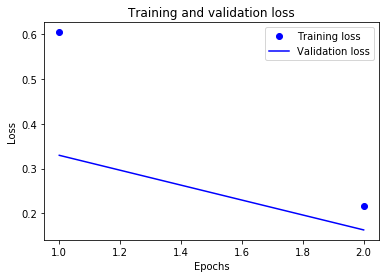

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

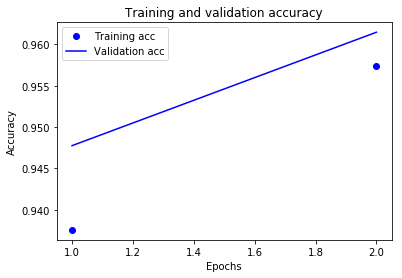

In [157]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
y_prob = model.predict_on_batch(x_val)
y_classes = y_prob.argmax(axis=-1)

y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame(y_classes, y_classes_val).reset_index().rename(columns={'index':'pred', 0:'val'})

len(df_val[df_val.pred==df_val.val])/len(df_val)

In [201]:
len([s.argmax() for s in y_prob if s.max()>.95])

2430

In [197]:
y_train[2]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [184]:
y_prob[0]

array([1.3658514e-06, 7.4803807e-05, 7.3278275e-06, 7.9822043e-05,
       9.0496486e-01, 8.8024892e-02, 7.5721636e-04, 4.3021572e-14,
       4.7702071e-07, 6.1204897e-05, 1.4966492e-04, 3.0131851e-06,
       3.2233221e-03, 1.3701534e-05, 1.5165291e-05, 5.0819141e-05,
       7.9642095e-06, 1.6862612e-07, 1.9958215e-03, 4.7775809e-04,
       1.2210985e-06, 1.3515674e-13, 8.4760832e-05, 1.7686153e-06,
       2.9462549e-06], dtype=float32)

In [203]:
y_prob = model.predict(x_train)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]

y_classes_val=y_train.argmax(axis=-1)

0.16151666666666667

In [209]:
df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})

len(df_val[df_val.pred==df_val.true])/len(df_val)

0.16151666666666667

In [212]:
df_95=df_val[df_val.prob>.95]

In [213]:
len(df_95[df_95.pred==df_95.true])/len(df_95)

0.1337448559670782

In [202]:
len(df_val[df_val.pred==df_val.val])

9691

In [171]:
df_val.val.unique()

array([18,  4, 13,  1, 19,  9, 24,  0, 23,  3,  6, 12, 17, 15, 11,  2, 10,
        8, 22,  7, 21,  5, 16, 14, 20], dtype=int64)

In [172]:
df_val.pred.unique()

array([ 4,  1, 15, 18, 13,  0,  5, 22, 11,  9, 12,  3, 23,  6],
      dtype=int64)

In [217]:
len(df_train)

229472

In [220]:
len(trainDF)

60000

In [221]:
trainDF.head()

,DLN,EIN,FILING_TYPE,IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt,IRS990EZ_p3_PrmryExmptPrpsTxt,IRS990PF_p16b_RltnshpSttmntTxt,IRS990PF_p9a_DscrptnTxt,IRS990ScheduleO_ExplntnTxt,IRS990_p1_ActvtyOrMssnDsc,IRS990_p3_DscS,...,RETURN_TYPE,SUB_DATE,TAXPAYER_NAME,TAX_PERIOD,YEAR,95_and_before,NTEE1,mission,prgrm_dsc,mission_prgrm
1593371,9.349307e+13,166011713,EFILE,NaN,NaN,NaN,NaN,,ENABLE PEOPLE IN THE COMMUNITY TO BREAK THE CY...,ENCOURAGING POSITIVE DEVELOPMENT - THE ORGANIZ...,...,990,3/27/2015,VOLUNTEERS OF AMERICA OF WESTERN NEW YORK INC,201406.0,2015.0,1.0,S,ENABLE PEOPLE IN THE COMMUNITY TO BREAK THE CY...,PROMOTING SELF-SUFFICIENCY - THE ORGANIZATION ...,ENABLE PEOPLE IN THE COMMUNITY TO BREAK THE CY...
1373465,9.349221e+13,200877262,EFILE,AMERICAN ADVERTISING FEDERATION DISTRICT 12 HE...,THE ORGANIZATION'S PURPOSE IS TO DEVELOP COOPE...,NaN,NaN,,NaN,NaN,...,990EO,10/15/2014 6:36:43 AM,AMERICAN ADVERTISING FEDERATION DISTRICT 12,201406.0,2014.0,0.0,S,THE ORGANIZATION'S PURPOSE IS TO DEVELOP COOPE...,AMERICAN ADVERTISING FEDERATION DISTRICT 12 HE...,THE ORGANIZATION'S PURPOSE IS TO DEVELOP COOPE...
1875314,9.349323e+13,20481705,EFILE,NaN,NaN,NaN,NaN,,Provide medical care to community - INACTIVE I...,Capital Region Physician Group (CRPG) was a pr...,...,990,10/10/2017 5:53:19 PM,CAPITAL REGION PHYSICIAN GROUP,201609.0,2017.0,0.0,E,Provide medical care to community - INACTIVE I...,Capital Region Physician Group (CRPG) was a pr...,Provide medical care to community - INACTIVE I...
2200617,9.349212e+13,43547470,EFILE,TO COMPENSATE COACHES TO TEACH BASEBALL SKILLS...,TO PROMOTE THE ATHLETIC SKILLS OF YOUNG MEN AN...,NaN,NaN,,NaN,NaN,...,990EZ,8/30/2017 8:02:11 AM,ACTON-BOXBOROUGH BASEBALL BOOSTERS INC,201612.0,2017.0,0.0,N,TO PROMOTE THE ATHLETIC SKILLS OF YOUNG MEN AN...,TO PROVIDE SCHOLORSHIPS TO SENIOR VARSITY PLAY...,TO PROMOTE THE ATHLETIC SKILLS OF YOUNG MEN AN...
1005974,9.349313e+13,237087103,EFILE,NaN,NaN,NaN,NaN,,"TO PROMOTE AND SUPPORT CHARITABLE, SCIENTIFIC ...",TO SUPPORT THE OPERATIONS OF PARK TUDOR FOUNDA...,...,990,7/22/2015,PARK TUDOR TRUST,201406.0,2015.0,1.0,B,"TO PROMOTE AND SUPPORT CHARITABLE, SCIENTIFIC ...",TO SUPPORT THE OPERATIONS OF PARK TUDOR FOUNDA...,"TO PROMOTE AND SUPPORT CHARITABLE, SCIENTIFIC ..."


In [222]:
df_val.head()

,pred,true,prob
0,4,18,0.904965
1,4,18,0.243975
2,4,4,0.172130
3,4,13,0.161313
4,1,1,0.240719
